<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S24_sorter_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
from gtbook.display import show, pretty
from gtbook.discrete import Variables
from ipywidgets import interact
import numpy as np
import gtsam

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"


# Perception
> Perception is the process of turning sensing measurements in actionable information.

In [3]:
from gtbook.display import randomImages
from IPython.core.display import display
display(randomImages(2, 4, "steampunk", 1))

We define perception to be the act of assigning probabilities to all possible states. In the previous section we learned about how to *model* sensors, and how to simulate how sensors work. However, in this section we want to invert that process: when given one or more measurements, *infer* what our state might be. In general, because sensors are not deterministic devices, we are only be able to pinpoint exactly what the state is: we end up with a probability distribution.

However, before going all probabilistic, we look at *maximum likelihood estimation* below. This is a simpler paradigm, and it also introduces some of the building blocks we need later.

## Maximum Likelihood

> Maximum likelihood estimation outputs the state that agrees most with the measurement.

Let us revisit the weight sensor from the previous section as an example. We first re-define it in code:

In [4]:
def Gaussian(x, mu=0.0, sigma=1.0):
    return np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi*sigma**2)
# Conditional weight density, mean and standard deviation specified in in grams:
pWC = np.array([[20, 10], [5, 5], [15, 5], [150, 100], [300, 200]])

Now, suppose an unknown object enters the sorting area, and the weight sensor outputs **50 grams**. What state is the most *likely* to agree with this measurement? One idea is to simply check the conditional probability $p(weight=30|Category)$ value for each of the possible categories. The following piece of code does that for our example:

In [5]:
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
for index, category in enumerate(categories):
    mu, sigma = pWC[index]
    print(f"{category:12}:{Gaussian(50, mu, sigma):.5f}")

cardboard   :0.00044
paper       :0.00000
can         :0.00000
scrap metal :0.00242
bottle      :0.00091


Above, we `enumerate` all possible categories, and use the `index` to pick out the parameters of the corresponding conditional Gaussian density. Then we just print it nicely.

We can see that choosing the `scrap metal` category for the state would the highest probability to the measurement $weight=50$. We say that `scrap metal` is the **maximum likelihood estimate** of the category given the measurement. Formally, we define it as

$$X^{ML} \doteq \arg \max_X p(Z=z|X).$$

In other words, we vary the *state* $X$ in the conditional probability while keeping the measurement $Z$ fixed, with known value $z$, and then single out the $X$ that maximizes the resulting number.



## The Likelihood Function
> Likelihoods are not probabilities.

It is convenient to define the **likelihood** of a state $X$ given the measurement $z$ is defined as any function $L(X;z)$ proportional to the conditional density $p(z|X)$:

$$L(X;z) \propto p(z|X).$$ 

The notation emphasizes that the measurement $z$ is given, and the likelihood is a function defined on the state $X$. This is something many people get confused about. It is the *state* that is likely or unlikely, not the measurement.

Let us define the likelihood function in code and plot it:

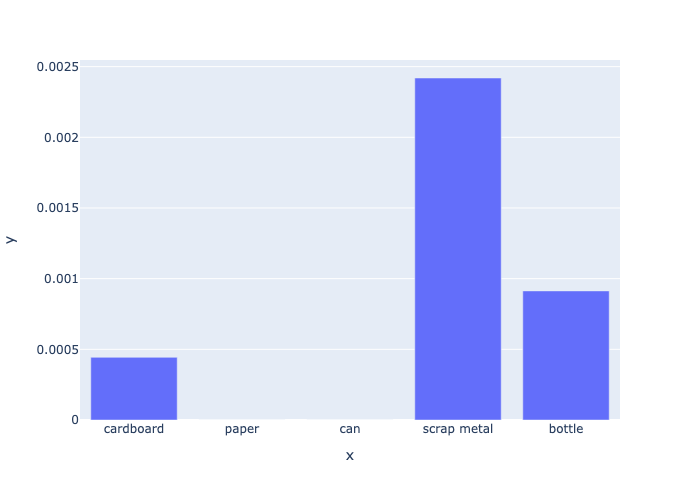

In [6]:
def likelihood(weight):
    return [Gaussian(weight, *pWC[index]) for index in range(5)]
L = likelihood(weight=50)
px.bar(y=L, x=categories)

As you can see, when we have a set of discrete categories, even a *continuous* sensor measurement will still induce a *discrete* likelihood function.
The plot also shows clearly that some categories are more likely than others. 

However, it is crucial to realize that the likelihood function $L(X;z)$ is itself **not** a probability distribution over the state $X$. Indeed, if we take the example from above and add the numbers, we get the following:

In [7]:
print(f"sum(L)={sum(L):.5f}")

sum(L)=0.00378


## Playing with Likelihoods

With some python notebook magic, we can create a fully interactive applet to explore how the likelihood function changes for different values of the measurement:

In [8]:
def likelihood_figure(weight):
    """Complicated figure to show likelihood for continuous case."""
    X = np.arange(0, 500)
    fig = make_subplots(
        rows=5, cols=2,
        column_widths=[0.6, 0.4],
        row_heights=[0.2, 0.2, 0.2, 0.2, 0.2],
        specs=[[{"type": "xy"}, {"type": "bar", "rowspan": 5}],
               [{"type": "xy"}, None],
               [{"type": "xy"}, None],
               [{"type": "xy"}, None],
               [{"type": "xy"}, None],
               ]
    )

    for index, category in enumerate(categories):
        fig.add_trace(
            go.Scatter(x=X, y=Gaussian(X, *pWC[index]), name=category),
            row=index+1, col=1
        )

    L = likelihood(weight)
    fig.add_trace(go.Bar(x=L[::-1], y=categories[::-1], orientation="h",
                  name="Likelihood"), row=1, col=2)
    return fig


In [9]:
# Evaluate this cell to interact with this figure:
@interact(weight=(0, 500, 5))
def show_likelihood(weight=50):
    display(likelihood_figure(weight))

interactive(children=(IntSlider(value=50, description='weight', max=500, step=5), Output()), _dom_classes=('wi…

## Likelihood Factors
> We can use a *factor* to represent the likelihood of an unknown state.

All of the perception algorithms in this book will heavily depend on likelihood functions, and we introduce a special data structure to conveniently represent them in code. For the Gaussian measurement model, we can instantiate a `DecisionTreeFactor` with the likelihood vector `L` we calculated above:

In [10]:
variables = Variables()
Category = variables.discrete("Category", categories)
factor = gtsam.DecisionTreeFactor(Category, L)
pretty(factor, variables)

Category,value
cardboard,0.000443185
paper,2.05595e-19
can,1.82694e-12
scrap metal,0.00241971
bottle,0.000913245


We can also define the likelihood of the category given the *discrete* detector output. This can be done by converting the conditional density to a factor. First, we define the sensor model as a conditional probability distribution:

In [11]:
Detection = variables.discrete("Detection", ["bottle", "cardboard", "paper"])

pDT = gtsam.DiscreteConditional(
    Detection, [Category], "2/88/10 2/20/78 33/33/34 33/33/34 95/2/3")
pretty(pDT, variables)


Category,bottle,cardboard,paper
cardboard,0.02,0.88,0.1
paper,0.02,0.2,0.78
can,0.33,0.33,0.34
scrap metal,0.33,0.33,0.34
bottle,0.95,0.02,0.03


After that, the likelihood functions correspond to the *columns* above: one column for each possible detection outcome. Again, note that these likelihood functions do *not* sum to 1.0: rows sum up to 1.0, but columns do not.

In GTSAM, a `DiscreteConditional` class actually has a handy `likelihood` method by which we can pick out the column. e.g., corresponding to the `cardboard` detection:

In [12]:
factor = pDT.likelihood(1)
pretty(factor, variables)

Category,value
cardboard,0.88
paper,0.2
can,0.33
scrap metal,0.33
bottle,0.02


The above is a *factor*.

Below is a small interactive applet that allows us to examine the likelihood of the trash category for every possible detection outcome:

In [13]:
values = ["bottle", "cardboard", "paper"]
@interact(detection=values)
def show_likelihood(detection="bottle"):
    index = values.index(detection)
    L_index = [v for (k,v) in pDT.likelihood(index).enumerate()]
    display(px.bar(x=L_index, y=categories))

interactive(children=(Dropdown(description='detection', options=('bottle', 'cardboard', 'paper'), value='bottl…

Picking out the most *likely* category only gets us so far, however: it us unclear on how to fuse multiple sensor measurements, or how to incorporate prior information. In fact, we can do better... we can use Bayes law to accomplish both goals. We will do so below.

Joint Distribution
------------------

If we consider the parameter $Y$ in a conditional probability
distribution not as a known parameter but as a random variable itself,
with probability distribution $P(Y)$ , we obtain a **joint probability
distribution** over the pair of variables $X$ and $Y$, and its PMF is
given by the **chain rule**: 

$$P(X,Y)=P(X|Y)P(Y)$$ 

To sample from a joint distribution $P(X,Y)$ we first sample a value $y$ from $P(y)$, as it does not depend on
any other variable, and then sample a value $x$ from the conditional
distribution $P(x|y)$.

Given a joint distribution $P(X,Y)$ we can ask what the probability is
of an outcome $x$ for $X$, irrespective of the value of $Y$. We call
this the **marginal probability distribution** of $X$, and it can be
calculated as

$$P(X)=\sum_{y}P(X,Y=y)$$ 

and of course we can also calculate the
marginal distribution of $Y$, in the same way: 

$$P(Y)=\sum_{x}P(X=x,Y)$$

We can also calculate the conditional distributions when given the joint
distribution, by taking the joint probability distribution and dividing
by the appropriate marginal: 

$$\begin{aligned}
P(X|Y) & =P(X,Y)/P(Y)\\
P(Y|X) & =P(X,Y)/P(X)\end{aligned}$$

This is really just the chain rule,
re-arranged.

## Example

| $a_i$ | *T=Left* | *T=Right* | *P(A)* |
|:-------:|:--------:|:---------:|:----:|
|   Left  |   0.18   |    0.14   | 0.32 |
|  Right  |   0.06   |    0.42   | 0.48 |
|    Up   |   0.03   |    0.07   | 0.10 |
|   Down  |   0.03   |    0.07   | 0.10 |
|   P(T)  |    0.3   |    0.7    |      |

The table above shows the joint probability 

$$P(A,T)=P(A|T)P(T)$$

The marginals $P(T)$ and $P(A)$ are also shown, respectively as row-wise and column-wise sums of the
$4\times2$ table of joint probabilities.

**Exercises**

1.  Calculate the conditional distribution $P(T|A)$ given the joint
    distribution $P(A,T)$ in Table
    <a href="#tab:joint" data-reference-type="ref" data-reference="tab:joint">4</a>.

2.  Viewing the integer coordinates $i$ and $j$ as separate random
    variables, use the distribution $P(i,j)=P(S)$ from Table
    <a href="#tab:prior-on-grid" data-reference-type="ref" data-reference="tab:prior-on-grid">1</a>
    and calculate the marginals $P(i)$ and $P(j)$.

3.  Similarly, what do the conditional probability tables for $P(i|j)$
    and $P(j|i)$ look like? Before you start calculating, ponder the
    relationship with Table
    <a href="#tab:prior-on-grid" data-reference-type="ref" data-reference="tab:prior-on-grid">1</a>.


## MAP Estimation
> We combine likelihoods with the prior (from Section 1.1) into a posterior. We introduce joint probabilities, the chain rule, and then Bayes law.



Our goal is to get a posterior probability over the possible classes:

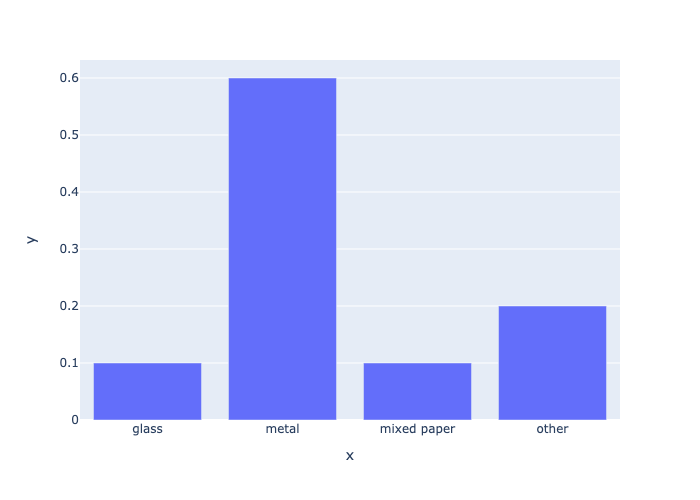

In [14]:
P = [0.1, 0.6, 0.1, 0.2]
assert np.sum(P)==1
px.bar(x=['glass', 'metal', 'mixed paper', 'other'],y=P)

## Bayes’ Rule

> Bayes’ Rule says that the posterior is the likelihood times the prior.

Given the formulas we discussed above, we can now derive Bayes’ rule,
which allows us to infer knowledge about a variable, say the robot state
$S$, given an observed sensor value $o$. The rule is named after the
reverend Thomas Bayes, an eighteenth century minister who took an
interest in probability later in life. He also lends his name to the
Bayes nets which we discuss in the next chapter.

Bayes’ rule allows us to calculate the **posterior probability
distribution** $P(S|O=o)$ on the variable $S$ given an observed value
for $O$. In Bayes’ rule we use the term “prior” to indicate knowledge we
have about a variable $S$ before seeing evidence for it, and use
“posterior” to denote the knowledge after having incorporated evidence.
In our case, the evidence is the observed value $o$. To calculate the
posterior, the elements we need are a prior probability distribution
$P(S)$, a conditional probability distribution $P(O|S)$ modeling the
measurement, and the value $o$ itself. Given these elements, we can
calculate the posterior probability distribution on $S$:

$$P(S|O=o)=\frac{P(O=o|S)P(S)}{P(O=o)}$$ 

The proof is simple and involves applying the chain rule in two ways:

$$P(O|S)P(S)=P(S,O)=P(S|O)P(O).$$

As we have already seen, because the observation is *known*, we can use the 
definition of the likelihood function

$$L(S;o)\propto P(O=o|S)$$ 

and substitute that in Bayes' law.
In addition, note that above the quantity $P(O=o)$ simply acts as a normalization constant. Given
these two facts, we can state Bayes’ rule in a more intuitive way - and
easier to remember - as

$$P(S|O=o)\propto L(S;o)P(S)$$ 

or “the posterior is proportional to the likelihood weighted by the prior.”

Note that above we developed this for discrete sensor, but for continuous sensors we have exactly the same expression, even though the likelihood $L(C;S) \propto p(S|C)$ is calculated by referring to a continuous density $p(S|C)$.

Finally, when actually computing a posterior there is not even a need to
think about anything but the joint distribution. Indeed, because by the
chain rule we have $P(O=o|S)P(S)=P(S,O=o)$, and because $P(O=o)$ is just
a normalization factor, we obtain a *third* form of Bayes’ rule, which
is the simplest of all:

$$P(S|O=o)\propto P(S,O=o)$$ 

Hence, if we are
given a formula or table of joint probability entries $P(S,O)$, it
suffices to just select all of them where $O=o$, normalize, and voilà!

### Exercises

1.  Apply Bayes’ rule to calculate the posterior probability $P(S|O=5)$,
    using the prior $P(S)$ from Table
    <a href="#tab:prior-on-grid" data-reference-type="ref" data-reference="tab:prior-on-grid">1</a>
    and the sensor model specified in Equation
    <a href="#eq:Noisy-sensor" data-reference-type="ref" data-reference="eq:Noisy-sensor">[eq:Noisy-sensor]</a>.

2.  Suppose we are interested in estimating the probability of an
    obstacle in front of the robot, given an "obstacle sensor" that is
    accurate $90\%$ of the time. Apply Bayes’ rule to this example by
    creating the sensor model, prior, and deriving the posterior.

3.  For the previous example, what happens if the sensor is random,
    i.e., it just outputs "obstacle detected" with 50% probability?

## Fusing Multiple Measurements

> Bayes law can easily accommodate multiple measurements as well. Applying the chain rule in two different ways:

$$P(S_1, S_2, C) = P(S_1, S_2| C) P(C) = P(C | S_1, S_2) P(S_1, S_2)$$

which gives us Bayes law for two sensor measurements:

$$P(C | S_1, S_2) = \frac{P(S_1, S_2| C) P(C)}{P(S_1, S_2)} \propto P(S_1, S_2| C) P(C) $$

We can simplify this even more by applying the chain rule once more, and using the fact that we know from Section 1.3 that a sensor measurement $S$ only depends on the category:

$$P(S_1, S_2| C) = P(S_1| S_2, C) P(S_2 | C) = P(S_1| C) P(S_2 | C)$$

And hence:

$$P(C | S_1, S_2) \propto P(S_1| C) P(S_2 | C) P(C)$$

Finally, by defining the likelihoods $L_i(C;S_i) \propto P(S_i|C)$, we finally have:

$$P(C | S_1, S_2) \propto L(C;S_1) L(C;S_2) P(C)$$

Note: if the category is *not* known, sensor measurements are not independent. Above, the category $C$ always appears behind the bar, which is our way of saying "given a *known* category".

